<a href="https://colab.research.google.com/github/kadenpoore/12/blob/main/Assignments/Scripts/advise_invest_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AdviseInvest

### Outline

Our Goals with this Project:

1. Import and review the data
2. Perform EDA and Clean Data
3. Fit a model
4. Test the accuracy of the model
6.  Use the model to predict on a new dataset (without the target)

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/Scripts/advise_invest_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### AdviseInvest Data Dictionary

Variable    |Description |Type    |Code
---- | ------- | ------ | -----
Answered       | Customer response |    Binary    |0: customer did not answer scheduled call; 1: customer answered scheduled call
Income       | Customer income in US dollars|	Numeric
Female       | Customer gender|	Binary	0: female; 1: male
Age	         | Age in years|	Numeric
Job          | Nature of job|	Categorical|	0 : unemployed; 1 : entry level position; 2 : midlevel position; 3 : management/ self-employed/ highly qualified employee/ officer
Num_dependents | Number of people for whom the customer provides maintenance|	Numeric
Rent	| Customer rents	|Binary	|0: no; 1: yes
Own_res	| Customer owns residence|	Binary|	0: no; 1: yes
New_car| Recent new car purchase	|Binary|	New car purchase in the last 3 months: 0: no, 1: yes
Chk_acct | Checking account status	|Categorical|	0 : no checking account; 1: checking < 200 USD; 2 : 200 < checking < 2000 USD; 3: 2000 < checking < 35000 USD; 4: >= 3500 USD
Sav_acct	| Average balance in savings account|	Categorical|	0 : no savings account; 1 : 100 <= savings < 500 USD; 2 : 500 <= savings < 2000 USD; 3 : 2000 < savings < 35000 USD; 4: >= 3500 USD
Num_accts	| Number of accounts owned by customer	|Numeric
Mobile	| Mobile phone	|Binary	|0: customer provided non‐mobile phone for follow‐up call; 1: customer provided mobile phone for follow‐up call
Product| Type of product purchased after conversation with sales rep	|Categorical|	0: customer did not answer call; 1: customer answered but did not purchase a product; 2: customer answered and purchased Beginner plan; 3: customer answered and purchased Intermediate plan; 4: customer answered and purchased Advanced plan



### Load Libraries

In this class we will be using
- Pandas
- Scikitlearn
- Matplotlib


In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


## Step 1: Initial Data Understanding

 - Import data from the AdviseInvest historical dataset into a dataframe (in GitHub go to Assignments > DataSets)
 - Describe or profile the dataframe
 - Look for any outliers, missing values, or duplicates

In [2]:
# Define the raw GitHub URL
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/main/Assignments/DataSets/adviseinvest_new_customer_data.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(df.head())

   income  female  age  job  num_dependents  rent  own_res  new_car  chk_acct  \
0   30010       0   40    2               1     1        0        0         1   
1   30510       0   54    2               1     0        1        0         0   
2   12880       0   48    2               2     0        1        0         0   
3   15530       0   44    2               1     0        1        0         0   
4   46230       0   40    3               1     0        1        0         3   

   sav_acct  num_accts  mobile customer_id  
0         0          3       0       H1597  
1         0          2       0       P1446  
2         1          4       0       E1492  
3         0          2       0       W5143  
4         1          2       0       W4927  


In [3]:
# Check for missing values
missing_values = df.isnull().sum()

# Check for duplicates
duplicates = df.duplicated().sum()

# Check for outliers using the IQR method
numeric_cols = df.select_dtypes(include=['number'])  # Select only numeric columns
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Outliers are values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).sum()

# Print the results
print("Missing Values:\n", missing_values[missing_values > 0])
print("\nNumber of Duplicates:", duplicates)
print("\nOutliers per Numeric Column:\n", outliers[outliers > 0])

Missing Values:
 Series([], dtype: int64)

Number of Duplicates: 0

Outliers per Numeric Column:
 income             67
female             50
age                26
job               383
num_dependents    139
rent              213
new_car           227
mobile            103
dtype: int64


In [ ]:
#Describe the data

## Step 2: Data Preparation

### 2.1: Data Cleanup
- Remove any variables that are not relevant to our analysis (if they relate to activity after the answer).
- Clean up the data and put it in a new datafram named "df_clean"


In [4]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number'])

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_clean = df[~((numeric_cols < lower_bound) | (numeric_cols > upper_bound)).any(axis=1)]

# Display the number of rows before and after removing outliers
print(f"Original dataset size: {df.shape[0]} rows")
print(f"Cleaned dataset size: {df_clean.shape[0]} rows")


Original dataset size: 1000 rows
Cleaned dataset size: 277 rows


In [5]:
# Display column names to verify correct names
print("Columns in dataset:", df.columns.tolist())

# Identify columns to drop based on redundancy or low value
columns_to_drop = [
    'Own_res',  # Redundant since 'Rent' provides similar info (if you rent, you don’t own)
    'Chk_acct',  # Checking account status may not be relevant for analysis
    'Mobile',  # Whether a phone is mobile or not is unlikely to affect financial decisions
    'New_car'  # Recent car purchase may not be useful for investment advice
]

# Drop only the columns that exist in the dataset
df_clean = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Display the remaining columns
print("Remaining columns after cleaning:", df_clean.columns.tolist())


Columns in dataset: ['income', 'female', 'age', 'job', 'num_dependents', 'rent', 'own_res', 'new_car', 'chk_acct', 'sav_acct', 'num_accts', 'mobile', 'customer_id']
Remaining columns after cleaning: ['income', 'female', 'age', 'job', 'num_dependents', 'rent', 'own_res', 'new_car', 'chk_acct', 'sav_acct', 'num_accts', 'mobile', 'customer_id']


In [6]:
from sklearn.preprocessing import MinMaxScaler


# Step 1: Remove duplicates
df = df.drop_duplicates()

# Step 2: Handle missing values
# Drop rows where all values are missing
df = df.dropna(how='all')

# Fill missing values appropriately
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:  # Numeric columns
        df[col].fillna(df[col].median(), inplace=True)
    else:  # Categorical and object columns
        df[col].fillna(df[col].mode()[0], inplace=True)

# Step 3: Convert categorical columns to appropriate types
categorical_columns = ['Job', 'Chk_acct', 'Sav_acct', 'Product']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype(str)  # Ensure categorical columns are strings

# Step 4: Convert binary columns to integer type (0/1)
binary_columns = ['Answered', 'Female', 'Rent', 'Own_res', 'New_car', 'Mobile']
for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].astype(int)

# Step 5: Normalize numeric columns using Min-Max Scaling
numeric_columns = ['Income', 'Age', 'Num_dependents', 'Num_accts']
scaler = MinMaxScaler()

# Ensure columns exist before applying scaler
existing_numeric_cols = [col for col in numeric_columns if col in df.columns]
if existing_numeric_cols:
    df[existing_numeric_cols] = scaler.fit_transform(df[existing_numeric_cols])

# Display cleaned dataset summary
print("Data after cleaning:")
print(df.info())
print(df.head())

# Optional: Check for any column names with leading or trailing spaces
print("Column names with possible spaces:")
print([col for col in df.columns if col != col.strip()])



Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   income          1000 non-null   int64 
 1   female          1000 non-null   int64 
 2   age             1000 non-null   int64 
 3   job             1000 non-null   int64 
 4   num_dependents  1000 non-null   int64 
 5   rent            1000 non-null   int64 
 6   own_res         1000 non-null   int64 
 7   new_car         1000 non-null   int64 
 8   chk_acct        1000 non-null   int64 
 9   sav_acct        1000 non-null   int64 
 10  num_accts       1000 non-null   int64 
 11  mobile          1000 non-null   int64 
 12  customer_id     1000 non-null   object
dtypes: int64(12), object(1)
memory usage: 101.7+ KB
None
   income  female  age  job  num_dependents  rent  own_res  new_car  chk_acct  \
0   30010       0   40    2               1     1        0        0       

<ipython-input-6-f9c795a409a9>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-6-f9c795a409a9>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

### 2.2: Standardize variables

 - Change "answered" to yes/no and make it categorical
 - Convert any variables that should be an integer into an integer

In [7]:
# Create the 'answered' column based on the 'mobile' column (proxy for answered)
df['answered'] = df['mobile'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Convert 'answered' to categorical (optional)
df['answered'] = pd.Categorical(df['answered'])

# Display the updated dataframe with 'answered' column
print(df[['mobile', 'answered']].head())



   mobile answered
0       0       No
1       0       No
2       0       No
3       0       No
4       0       No


In [8]:
# Convert the 'answered' column from categorical (Yes/No) to integers (1/0)
df['answered'] = df['answered'].apply(lambda x: 1 if x == 'Yes' else 0)

# Display the updated dataframe with 'answered' as integer
print(df[['mobile', 'answered']].head())

   mobile answered
0       0        0
1       0        0
2       0        0
3       0        0
4       0        0


### 2.3 Convert variables to categorical

- Find at least 8 variables that would be appropriate to convert to categories

In [9]:
# List of variables to convert to categorical
categorical_columns = ['job', 'chk_acct', 'sav_acct', 'rent', 'own_res', 'new_car', 'mobile', 'product']

# Convert these columns to categorical
for col in categorical_columns:
    if col in df.columns:
        df[col] = pd.Categorical(df[col])

# Display the updated dataframe info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   income          1000 non-null   int64   
 1   female          1000 non-null   int64   
 2   age             1000 non-null   int64   
 3   job             1000 non-null   category
 4   num_dependents  1000 non-null   int64   
 5   rent            1000 non-null   category
 6   own_res         1000 non-null   category
 7   new_car         1000 non-null   category
 8   chk_acct        1000 non-null   category
 9   sav_acct        1000 non-null   category
 10  num_accts       1000 non-null   int64   
 11  mobile          1000 non-null   category
 12  customer_id     1000 non-null   object  
 13  answered        1000 non-null   category
dtypes: category(8), int64(5), object(1)
memory usage: 56.0+ KB
None


In [10]:
# Create the 'answered' column based on the 'mobile' column (proxy for answering)
df['answered'] = df['mobile'].apply(lambda x: 1 if x == 1 else 0)

# Display the updated dataframe with 'answered' column
print(df[['mobile', 'answered']].head())

  mobile answered
0      0        0
1      0        0
2      0        0
3      0        0
4      0        0


# Step 3: Exploratory Data Analysis (EDA)
- Explore the relationships between the target and independent variables
- Create at least five charts to show the relationships, using different chart types that are approriate to the analysis
- Ensure that all charts are clearly labeled and formatted

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

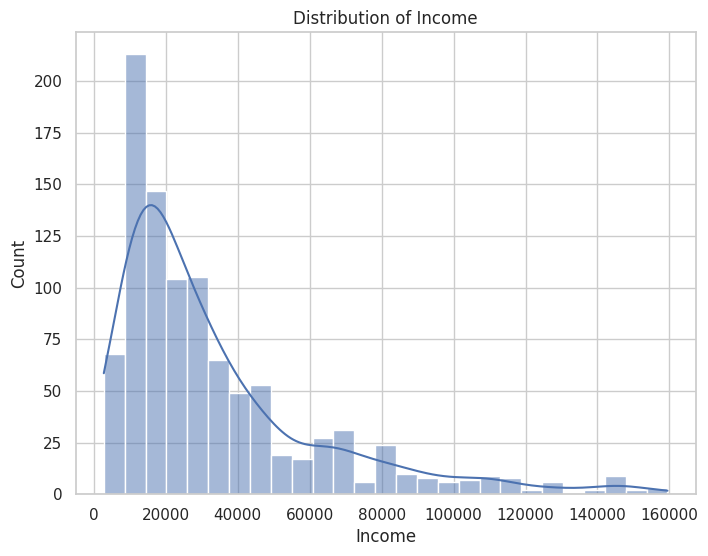

In [31]:
# prompt: create a chart

import matplotlib.pyplot as plt
# Assuming 'df' is your DataFrame (from the previous code)

# Chart 1: Distribution of Income
# Changed 'Income' to 'income' to match the actual column name
plt.figure(figsize=(8, 6))
sns.histplot(df['income'], kde=True)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt

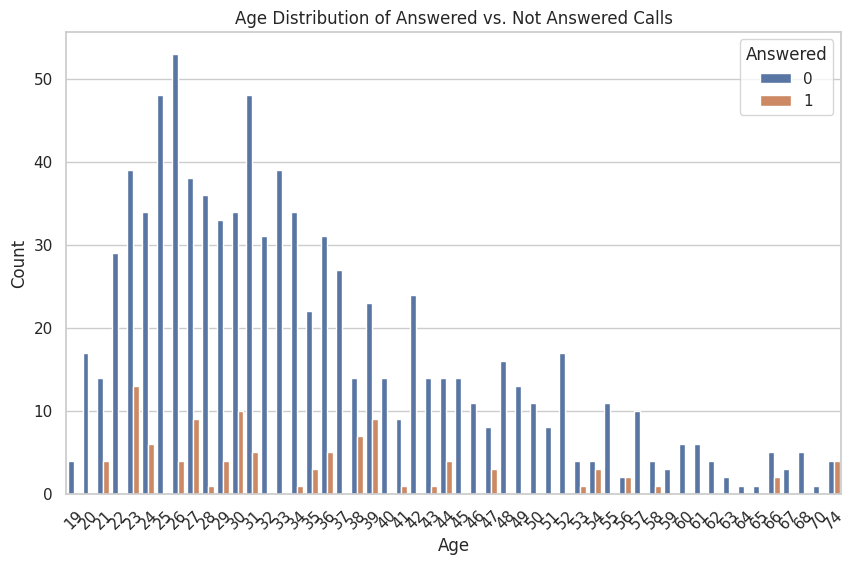

In [33]:
# prompt: create a chart showing ages of answered and didn't

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame from the previous code

# Create a countplot of 'age' (lowercase) grouped by 'answered'
plt.figure(figsize=(10, 6))
sns.countplot(x='age', hue='answered', data=df)  # Changed 'Age' to 'age'
plt.title('Age Distribution of Answered vs. Not Answered Calls')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Answered')
plt.show()

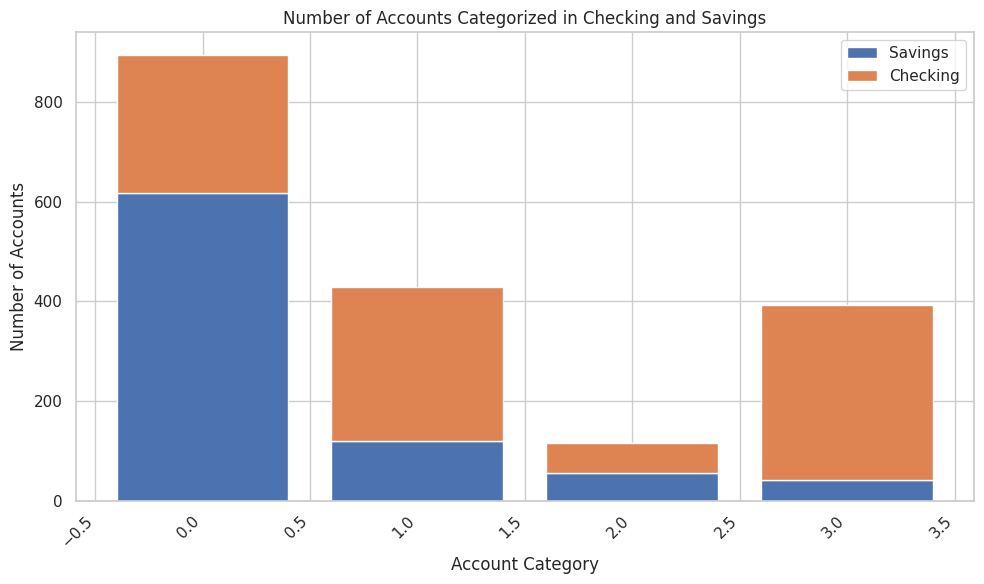

In [35]:
# prompt: create a chart showing the number of accounts categorized in checking and savings

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame from the previous code

# Count the occurrences of each 'sav_acct' category
savings_counts = df['sav_acct'].value_counts()

# Count the occurrences of each 'chk_acct' category
checking_counts = df['chk_acct'].value_counts()

# Get the common categories between savings and checking accounts
common_categories = savings_counts.index.intersection(checking_counts.index)

# Filter the counts to include only common categories
savings_counts = savings_counts.loc[common_categories]
checking_counts = checking_counts.loc[common_categories]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(savings_counts.index, savings_counts.values, label='Savings')
plt.bar(checking_counts.index, checking_counts.values, label='Checking', bottom=savings_counts.values)  # Now, shapes should match

# Customize the chart
plt.xlabel('Account Category')
plt.ylabel('Number of Accounts')
plt.title('Number of Accounts Categorized in Checking and Savings')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.legend()
plt.tight_layout()
plt.show()

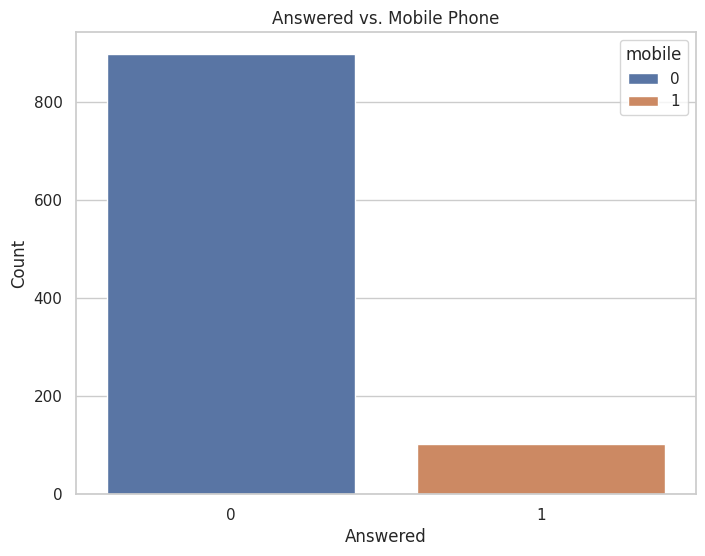

In [37]:
# prompt: create a chart showing answered and mobile

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it contains 'answered' and 'mobile' columns.
# Create the plot
plt.figure(figsize=(8, 6))
sns.countplot(x='answered', hue='mobile', data=df)
plt.title('Answered vs. Mobile Phone')
plt.xlabel('Answered')
plt.ylabel('Count')
plt.show()


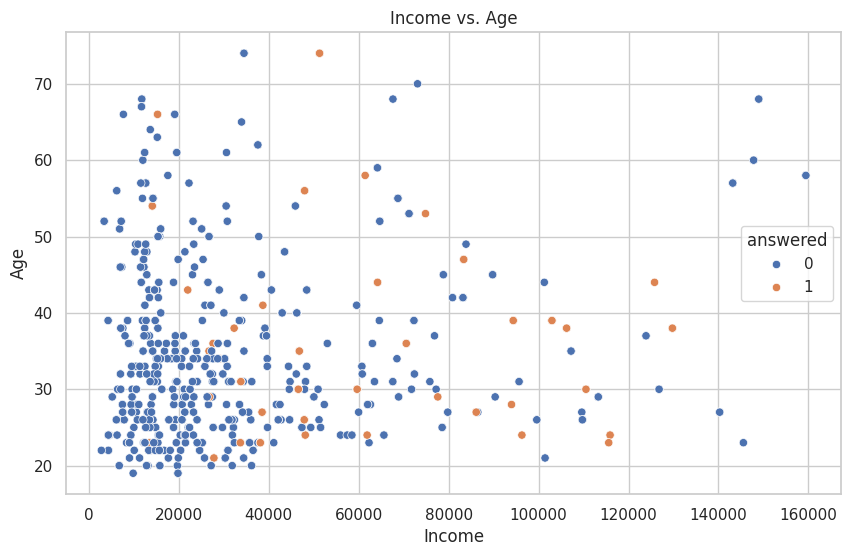

In [39]:
# prompt: create a chart showing the relationship between 2 important variables

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame and contains 'income' and 'age' columns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='income', y='age', data=df, hue='answered') # Replace 'answered' with your target variable if different
plt.title('Income vs. Age')
plt.xlabel('Income')
plt.ylabel('Age')
plt.show()


In [46]:
from google.colab import drive
drive.mount('/content/drive')

!jupyter nbconvert --to html "advise_invest_template-4.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook advise_invest_template-4.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).
[NbConvertApp] Writing 697209 bytes to advise_invest_template-4.html


In [41]:
import pandas as pd

# Assuming your DataFrame is called df
df['answered'] = df['answered'].map({0: 'no', 1: 'yes'}).astype('category')


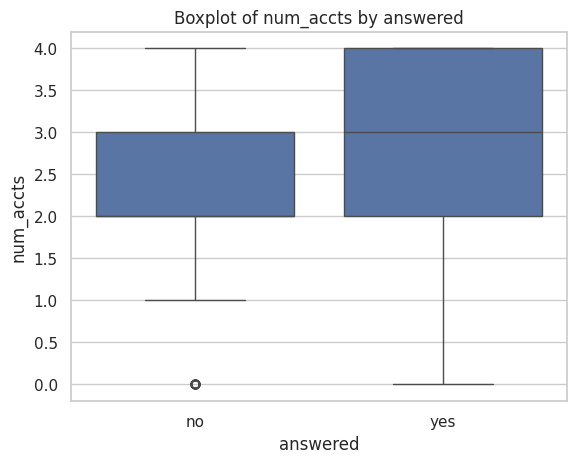

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot
sns.boxplot(x='answered', y='num_accts', data=df)
plt.title('Boxplot of num_accts by answered')
plt.show()

In [43]:
import pandas as pd

# Assuming your DataFrame is called df
df['mobile'] = df['mobile'].astype('category')


In [44]:
# Count the number of occurrences of 'answered' for each 'mobile' category
summary_table = df.groupby(['mobile', 'answered']).size().unstack(fill_value=0)


<ipython-input-44-1e3e1681d6eb>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = df.groupby(['mobile', 'answered']).size().unstack(fill_value=0)


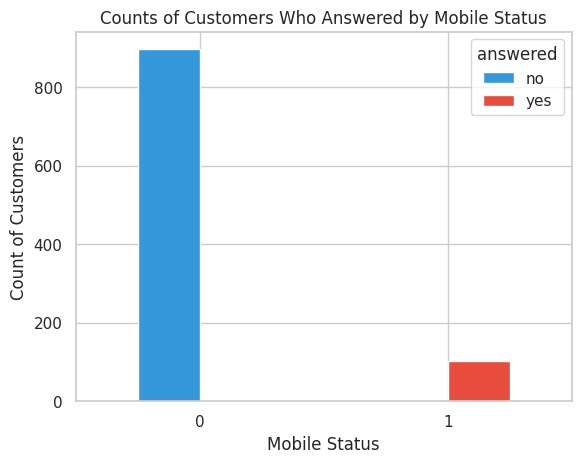

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the barplot of the counts
summary_table.plot(kind='bar', stacked=False, color=["#3498db", "#e74c3c"])

# Set the title and labels
plt.title('Counts of Customers Who Answered by Mobile Status')
plt.xlabel('Mobile Status')
plt.ylabel('Count of Customers')
plt.xticks(rotation=0)  # To make the x-axis labels readable

# Show the plot
plt.show()


## Step 4: Modeling

### 4.1: Calculate the base probability of answering

If we use no model at all, how good is our chance of predicting someone leaving?

In [ ]:
#get the default probability

### 4.2: Split the training and testing datasets

- split df_clean using train_test_split function
- all variables except answered should be in the x variable
- answered is in the y variable


In [ ]:
# Split data into training and testing sets


### 4.3: Create a Decision Tree
- Use all available attributes (except those that were eliminated in step 3)
- It is recommended to use the type "entropy" and a max_depth of 4

In [ ]:
#create a tree

In [ ]:
#display (visualize) the tree

### 4.4: What is the accuracy?

This should be better than the base probability, or you have failed in your objective

In [ ]:
#calculate the probability for your tree

### 4.5: Create a confusion matrix

This will show false positives, true positives, etc.

In [ ]:
#create a basic confusion matrix


Create a more visual, interpretable version of the matrix

In [ ]:
#Create a beautiful matrix; hint - try using Seaborn Heatmap

# Step 5: Evaluate the Model

**Assumptions**

One of the simplifying assumptions we will make in this project is that all the customers who answer the phone will purchase a product. (This assumption is actually verified by the data.) To model "answered" in this case is therefore equivalent to modeling "purchased."

There are costs and benefits in this case. We will assume that customers purchase a product for 100 dollars. This was the average cost of AdviseInvest products, according to the Director of Sales.  Also, as we learned in the interview, the agent time to make the sale is worth 25 dollars. Profit would therefore be \$75 dollars for an answered call and a purchase. In sum:

**Benefit**: True positive. The customer is predicted to answer, does answer, and purchases a product for 100 dollars for a profit of 100 - 25 = 75.

**Cost**: False positive. The customer is predicted to answer, but does not answer, so there is a loss of 25. (We assume the agent cannot schedule another call at the last minute, or spends the entire time slot trying to make the call.)

When you create a calculation you can use:
- True answered * 75 -> These people purchased
- False answered * 25 -> You can't schedule another call

For this exercise, we propose that customers who are not predicted to answer will not be called, so there would be no benefits and no costs for them.  

### 5.1 Calculate the Profit Using the Model

In [ ]:
# Write a calcuation for the profit from your model

### 5.2 Compare to the Default Profit

How much profit (revenue - costs) could be expected if all customers are called? We can consider this a baseline case for profit since it does not require a model.

In other words, to calculate profit in this baseline scenario treat the customers who answer as true positives treat the customers who do not answer as false positives.

In [ ]:
#Write a calculation for the overall profit without using the model (default)

### 5.3 Tune the Model
- Adjust the size or shape of the tree, then test the accuracy
- Continue to make changes until you find a set of hyperparameters that improves the accuracy compared to the initial model

In [ ]:
# Create a new version of the tree with new parameters

In [ ]:
# Calculate a new probability

### 5.4 Apply the Model to New Customers
- Import the "adviseinvest_new_customer_data.csv" file
- Using the tree model, predict each customer for the target variable

In [ ]:
#Import new customer data into a new data frame

In [ ]:
#Predict the number of customers who will be yes/no for the target variable

# Step 6: Plan for Deployment
### 6.1: Did we improve our profit using the model?  

Write your conclusion notes below:

### 6.2: How should the model be deployed?

Write your recommendations below: